In [17]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import pdb
from tqdm.auto import tqdm
import numpy as np
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader

from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab import Trainer, PrioritisedBufferTrainer
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import importlib 
import models.ddpm
importlib.reload(models.ddpm)
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

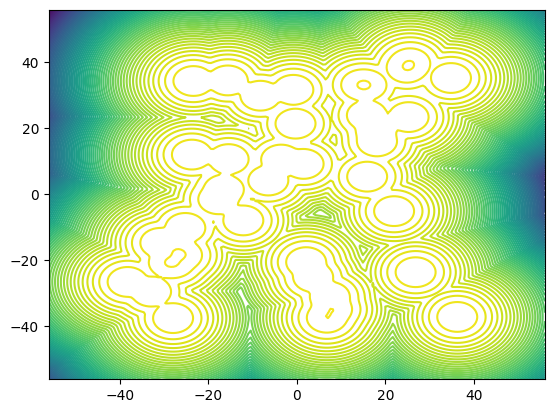

In [5]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0

torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=True, true_expectation_estimation_n_samples=int(1e5))
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to("cuda")

In [7]:
def plot_dataset(samples):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=ax, n_contour_levels=50, grid_width_n_points=200)
    target.to("cuda")
   
    # plot dataset samples
    plot_marginal_pair(samples, ax=ax, bounds=plotting_bounds)
    
    ax.set_title("Dataset samples")
    plt.show()
    return [fig]

In [8]:
def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    mins = torch.min(x, dim=0)[0]
    maxs = torch.max(x, dim=0)[0]
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    # x = x * 2 - 1
    return x, mins, maxs

def unnormalize(x, mins, maxs):
    '''
        x : [ 0, 1 ]
    '''
    assert x.max() <= 1 and x.min() >= 0, f'x range: ({x.min():.4f}, {x.max():.4f})'
    return x * (maxs - mins) + mins

### Dataset

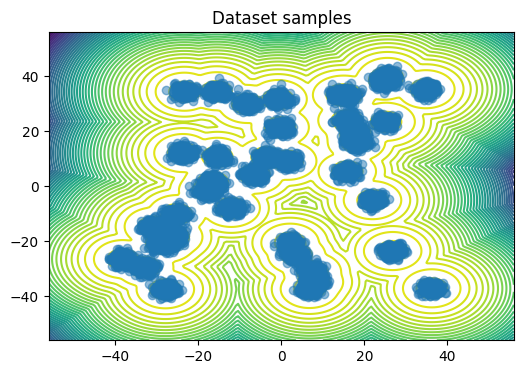

In [24]:
num_samples = 10000
dataset = target.sample(torch.tensor(num_samples).unsqueeze(0))

plot_dataset(dataset) # Visualise model during initialisation.
plt.show()

In [25]:
num_train_epochs = 200
dataset, global_mins, global_maxs = normalize(dataset)
train_dataset = TensorDataset(dataset)
trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True) 

### Networks

In [26]:
model = MyMLP().to(device)

diffusion_model = GaussianDiffusion(
    model,
    image_size = 2,
    timesteps = 1000    # number of steps
).to(device)

opt = Adam(diffusion_model.parameters(), lr=1e-3)

### Training

In [27]:
global_step = 0
for epoch in range(num_train_epochs):
    progress_bar = tqdm(total=len(trainloader))
    progress_bar.set_description(f"Epoch {epoch}")

    total_loss = 0.
    for _, data in enumerate(trainloader):
        opt.zero_grad()

        data = data[0].to(device)
        loss = diffusion_model(data)    
        # clip_grad_norm_(diffusion_model.parameters(), 1.0)
    
        total_loss += loss.item()
        loss.backward()
        opt.step()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        progress_bar.set_postfix(**logs)
        global_step += 1

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [28]:
sampled_points = diffusion_model.sample(batch_size = 1000)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

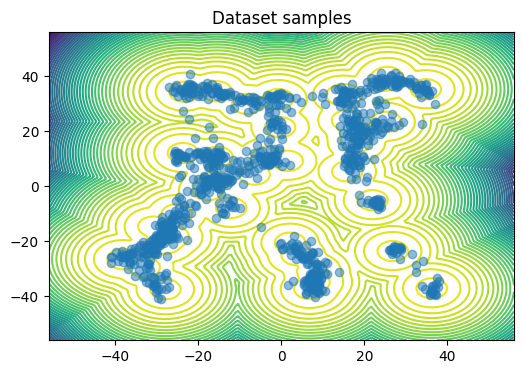

In [29]:
plot_dataset(unnormalize(sampled_points, global_mins, global_maxs))
plt.show()